In [3]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

import pandas as pd

## Trainer and functions to predict

In [7]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()

        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [8]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)

    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score

    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

## Data exploration
Worked on [kaggle](https://www.kaggle.com/competitions/aptos2019-blindness-detection/data) 

In [ ]:
DATA_PATH = '/kaggle/input/aptos2019-blindness-detection/'

In [44]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

The whole dataset contains 3662 images

Distribution of classes:


,0,1,2,3,4
Count,1805,370,999,193,295


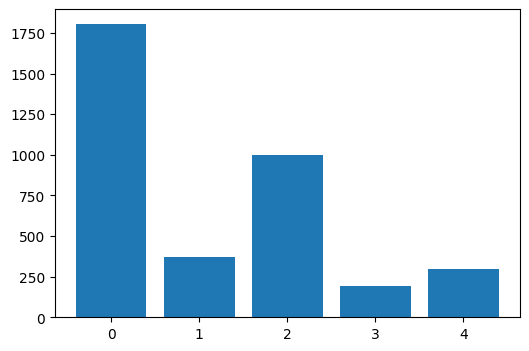

In [62]:
number_whole_data = train.shape[0]
print(f"The whole dataset contains {number_whole_data} images")
print('')
count_table = pd.DataFrame()

for number_class in range(5):
    count_image = train.loc[train['diagnosis'] == number_class].count().array[0]
    count_class = pd.DataFrame({str(number_class): [count_image]}, index=['Count'], dtype='category')
    count_table = pd.concat([count_table, count_class], axis=1)
    
print("Distribution of classes:")
display(count_table)

fig = plt.subplots(figsize=(6, 4))
labels = count_table.columns
counts = count_table.loc['Count'].array
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show();

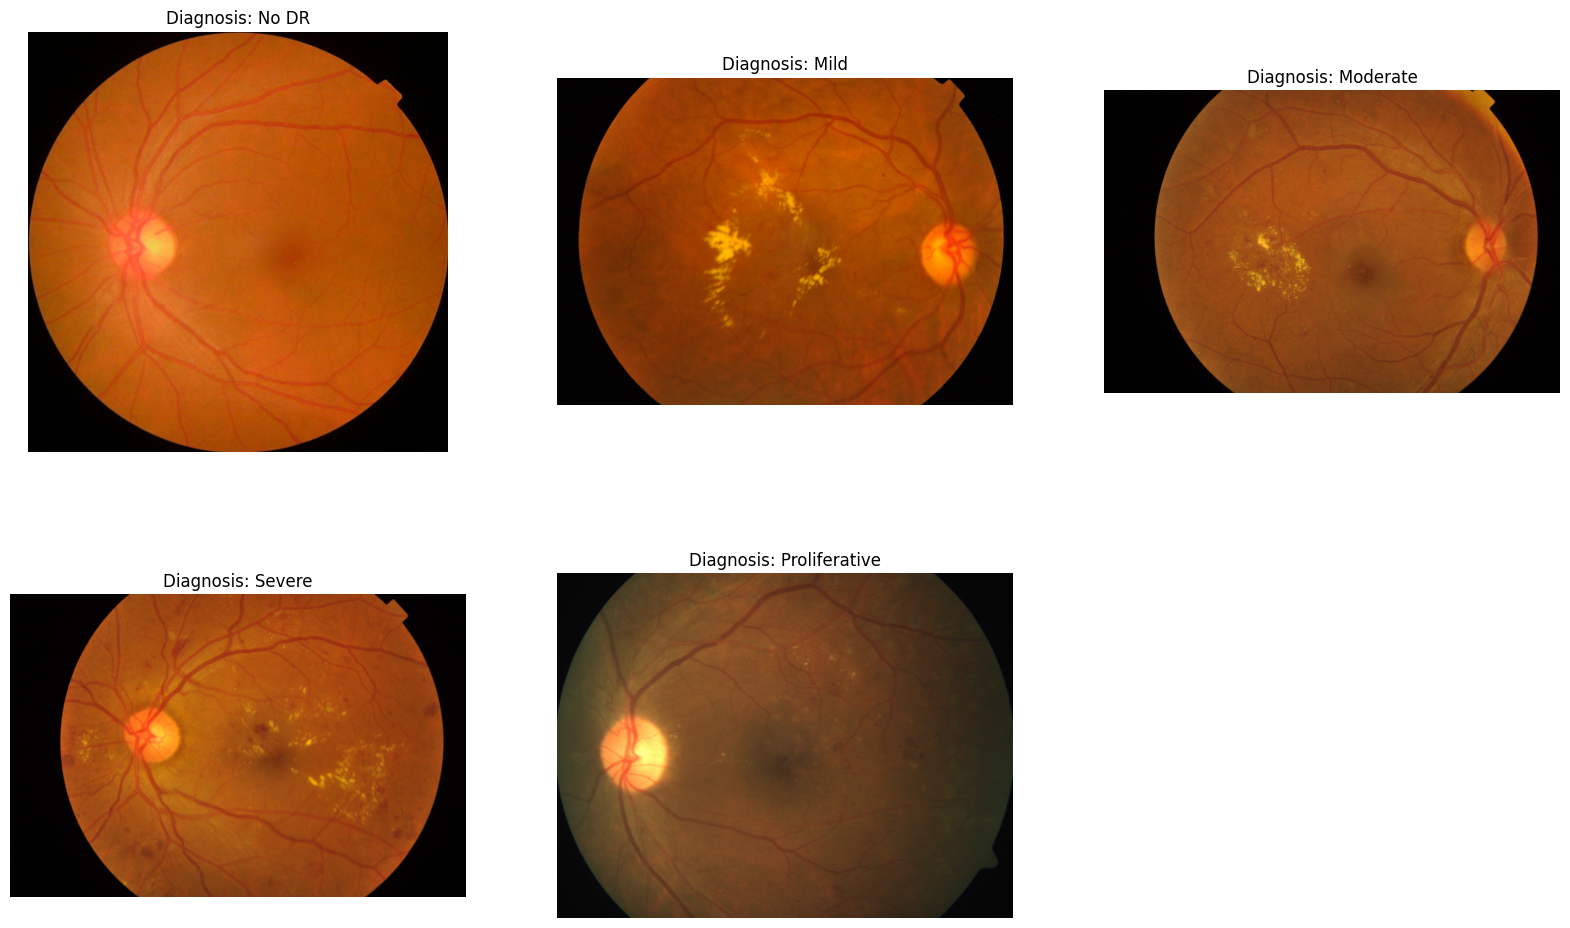

In [91]:
name_diagnosis = {0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative'}
fig = plt.figure(figsize=(20, 12))
train_img_paths = os.listdir(os.path.join(DATA_PATH, 'train_images'))
for number_class in range(5):
    plt.subplot(2, 3, number_class + 1)
    id_code = np.random.choice(train.loc[train['diagnosis'] == number_class]['id_code'], 1)[0]
    image = Image.open(os.path.join(DATA_PATH, 'train_images', id_code + '.png'))
    name_label = name_diagnosis[number_class]
    plt.title(f'Diagnosis: {name_label}')
    plt.imshow(image)
    plt.axis("off") 

## Dataset and DataLoader

In [11]:
train_val_files = sorted(list(Path(os.path.join(DATA_PATH, 'train_images')).rglob("*.png")))

train_val_labels = []
for path in train_val_files:
    id_code = path.parts[-1].split('.png')[0]
    label = train.loc[train.id_code == id_code, 'diagnosis'].array[0]
    train_val_labels.append(label)

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
N_CLASSES = len(set(train_val_labels))
N_CLASSES

5

In [10]:
RESCALE_SIZE = 224, 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

print(f"Using device: {DEVICE}")

Using device: cuda


In [15]:
class OcularDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()
        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.mode = mode

        self.labels = []
        for path in self.files:
            id_code = path.parts[-1].split('.png')[0]
            label = train.loc[train.id_code == id_code, 'diagnosis'].array[0]
            self.labels.append(label)
        self.label_encoder.fit(self.labels)

        if self.mode == "train":
            with open("label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomHorizontalFlip(p=0.4),
                        transforms.ToTensor(),
                        transforms.Normalize([0.4064, 0.2169, 0.0722], 
                                             [0.2786, 0.1515, 0.0811])
                        ])
                        

        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize([0.4064, 0.2169, 0.0722], 
                                             [0.2786, 0.1515, 0.0811])
                        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

In [16]:
trainset = OcularDataset(train_files)
valset = OcularDataset(val_files, mode="val")

class_numbers_train = Counter(trainset.labels)
samples_weight_train = torch.tensor([1 / class_numbers_train[i] for i in trainset.labels])

class_numbers_val =  Counter(valset.labels)
samples_weight_val = torch.tensor([1 / class_numbers_val[i] for i in valset.labels])

sampler_train = WeightedRandomSampler(samples_weight_train.type("torch.DoubleTensor"), len(samples_weight_train))
sampler_val = WeightedRandomSampler(samples_weight_val.type("torch.DoubleTensor"), len(samples_weight_val))

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler_train)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, sampler=sampler_val)

## Model training

In [25]:
model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights)

model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=5, bias=True))

for name, child in model.named_children():
    if name in ['layer2','layer3','layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [28]:
trainer_11 = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
trainer_11.fit()

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 1 out of 10: Train loss = 0.9859558988449185, validation loss = 0.9355202008937967 
                                         Train metric = 0.57319737800437, validation metric = 0.5938864628820961

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 2 out of 10: Train loss = 0.7048119895680006, validation loss = 0.910895895341347 
                                         Train metric = 0.6879096868171887, validation metric = 0.5633187772925764

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 3 out of 10: Train loss = 0.5366971340290335, validation loss = 1.274279080588242 
                                         Train metric = 0.7363437727603788, validation metric = 0.6320960698689956

Training: batch 86 out of 86
Validation: batch 29 out of 29

Epoch 4 out of 10: Train loss = 0.433330935967523, validation loss = 1.0565390771832959 
                                         Train metric

KeyboardInterrupt: 

In [32]:
from functools import partial

f1_macro = partial(f1_score, average="macro")

Accuracy on 7 epochs with 32 batches is 0.6550218340611353
F1 score on 7 epochs with 32 batches is 0.6515632043344285


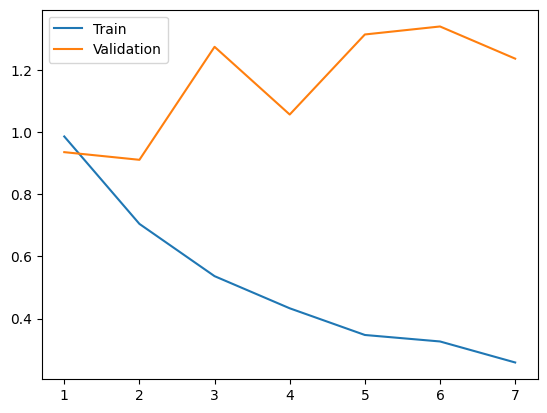

In [33]:
accuracy = calculate_metric(model, valloader)
f1_score = calculate_metric(model, valloader, f1_macro)

n_epochs = len(trainer_11.train_losses)
print(f'Accuracy on {n_epochs} epochs with {BATCH_SIZE} batches is {accuracy}')
print(f'F1 score on {n_epochs} epochs with {BATCH_SIZE} batches is {f1_score}')

sns.lineplot(y=trainer_11.train_losses, x=range(1, n_epochs + 1), label="Train")
sns.lineplot(y=trainer_11.valid_losses, x=range(1, n_epochs + 1),label="Validation")

plt.show()

In [34]:
torch.save(model.state_dict(), '7_resnet152_bs32_stclass_ft_7epoh_myparam.pt')

## Data check

In [198]:
def predict_one_sample(model, image, device=DEVICE) :
    with torch.no_grad():
        transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize([0.4064, 0.2169, 0.0722], 
                                             [0.2786, 0.1515, 0.0811])
                        ])
        image_tensor = transform(image)
        image_sample = image_tensor.unsqueeze(0)
        image_sample = image_sample.to(device)
        model.eval()
        logit = model(image_sample).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        prob = np.max(probs)
        name_class = np.argmax(probs)
    return name_class, prob

In [200]:
name_diagnosis = {0: 'No DR', 
                  1: 'Mild', 
                  2: 'Moderate', 
                  3: 'Severe', 
                  4: 'Proliferative'}

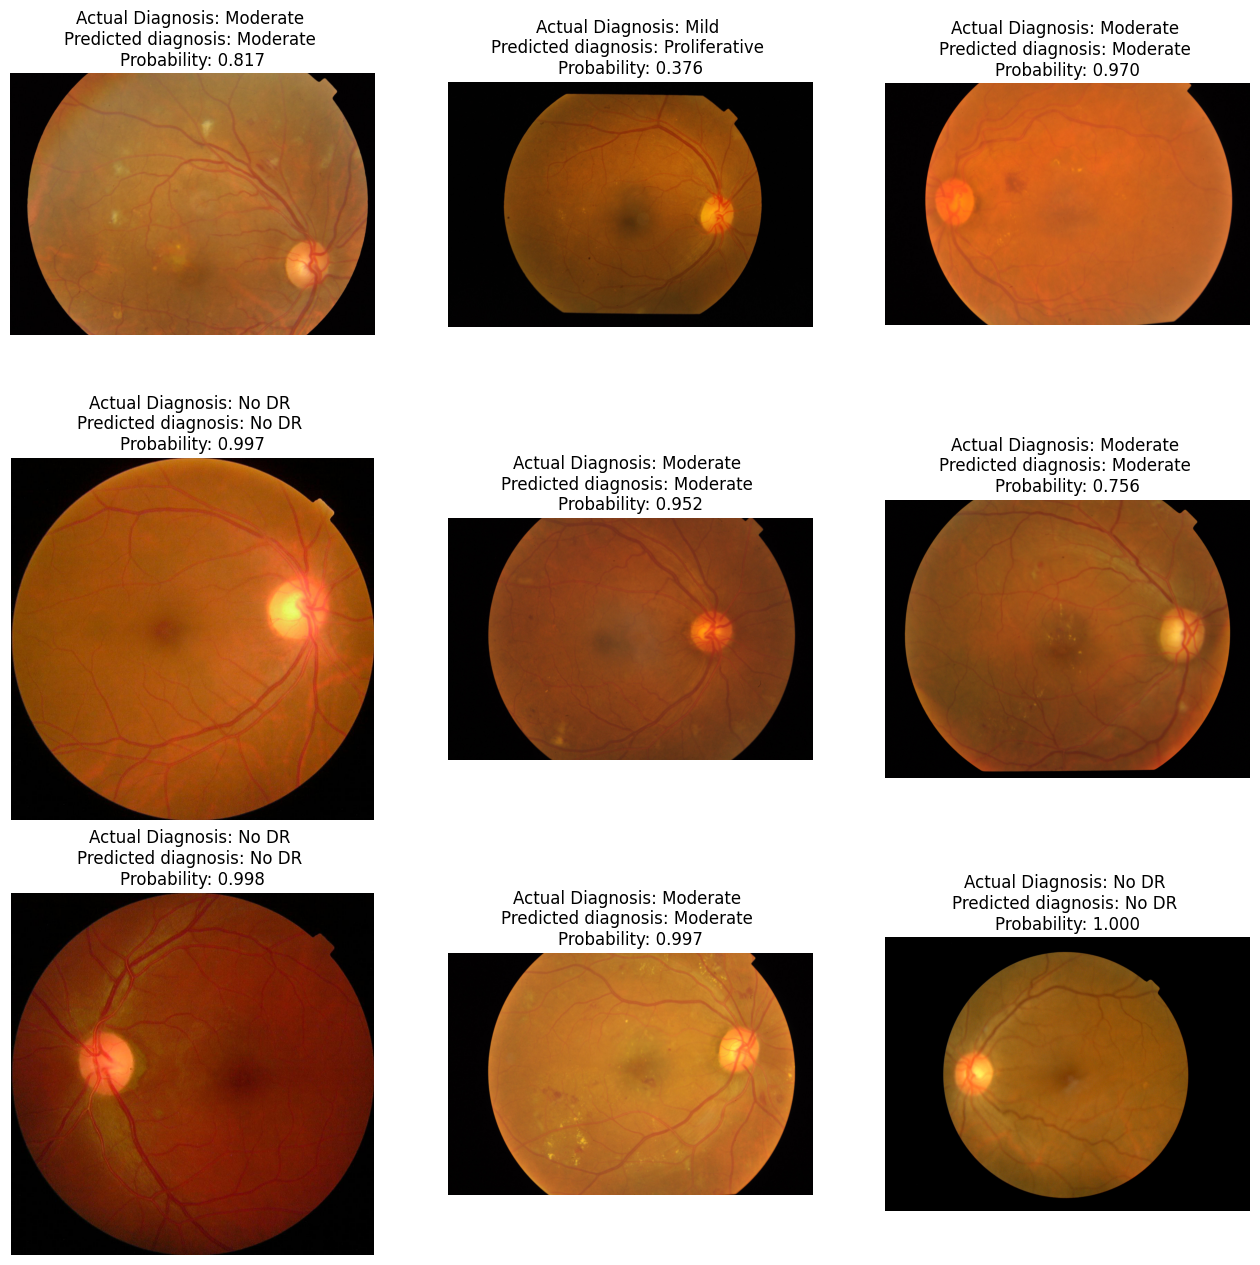

In [214]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16))
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 916))
    label = valset[random_characters][1]
    diagnosis = name_diagnosis[label]
    im_val = Image.open(valset.files[random_characters])
    plt.axes(fig_x)
    plt.imshow(im_val, axes=fig_x)
    plt.axis('off')
    font.set_family("fantasy")
    y_pred, predicted_proba = predict_one_sample(model, im_val)
    pred_diagnosis = name_diagnosis[y_pred]
    title = (f'Actual Diagnosis: {diagnosis} \n'
             f'Predicted diagnosis: {pred_diagnosis} \n'
             f'Probability: %0.3f'%predicted_proba)
    plt.title(title)
    plt.savefig('ocul_fundus_pred1.png', bbox_inches="tight", dpi=300)

## Download model

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('/kaggle/working/7_resnet152_bs32_stclass_ft_7epoh_myparam.pt'))
model.eval()